0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
1

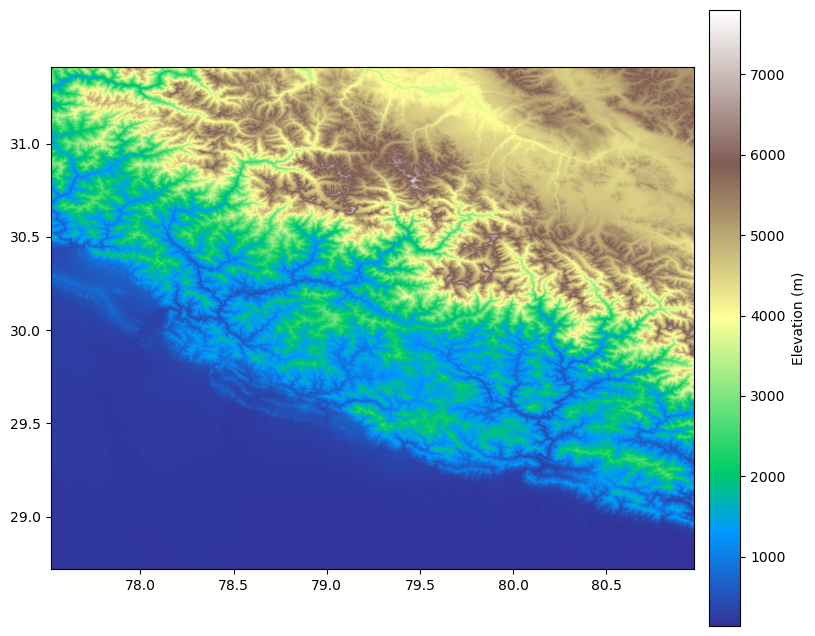

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.animation import FuncAnimation

# Function to convert DMS to decimal degrees
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# Function to calculate the Haversine distance between two points in kilometers
def haversine(coord1, coord2):
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Earth radius in kilometers
    r = 6371.0
    return r * c

# PSO Algorithm to find the best centers
def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data):
    # Initialize particles
    particles = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=(num_particles, num_centers, 2))
    velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))

    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = np.array([fitness(p, data, distance, terrain_data, bounds) for p in particles])
    g_best = p_best[np.argmax(p_best_fitness)]
    g_best_fitness = np.max(p_best_fitness)

    # Initialize particle history
    particle_history = []

    # PSO iterations
    for iteration in range(num_iterations):
        for i in range(num_particles):
            print(iteration)
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], [bounds[0], bounds[2]], [bounds[1], bounds[3]])

            # Update personal best
            current_fitness = fitness(particles[i], data, distance, terrain_data, bounds)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i]
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i]
                    g_best_fitness = current_fitness

        # Store particle positions for animation
        particle_history.append(particles.copy())

    # Return the best particles, best fitness, and particle history
    return g_best, g_best_fitness, particle_history

# Function to check if a point is within the given distance from another point using Haversine formula
def covers(point, target, distance):
    return haversine(point, target) <= distance

# Function to evaluate fitness of a particle
def fitness(particle, data, distance, terrain_data, bounds):
    total_coverage = 0
    for point in data:
        for center in particle:
            if covers(center, point, distance):
                lat_index = int((point[0] - bounds[0]) / terrain_data.res[0])
                lon_index = int((point[1] - bounds[2]) / terrain_data.res[1])
                elevation = terrain_data.read(1)[lat_index, lon_index]
                if 0 <= elevation <= 2000:
                    total_coverage += 1
                    break
    return total_coverage


# Define the PSO parameters
num_particles = 30  # Number of particles in the swarm
num_iterations = 100  # Number of iterations to run the PSO
w = 0.5  # Inertia weight
c1 = 1.5  # Cognitive (particle) weight
c2 = 1.5  # Social (swarm) weight

# Define the bounds for the search space in decimal degrees
bounds = [
    min(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),
    max(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),  # Latitude bounds
    min(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E')),
    max(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E'))   # Longitude bounds
]

# Define the data points (converted to decimal degrees)
data = np.array([
    [dms_to_dd(30, 18, 40, 'N'), dms_to_dd(78, 2, 9, 'E')],
    [dms_to_dd(29, 56, 43, 'N'), dms_to_dd(78, 9, 4, 'E')],
    [dms_to_dd(29, 52, 43, 'N'), dms_to_dd(77, 53, 15, 'E')],
    [dms_to_dd(30, 13, 32, 'N'), dms_to_dd(78, 46, 58, 'E')],
    [dms_to_dd(30, 8, 42, 'N'), dms_to_dd(78, 45, 59, 'E')],
    [dms_to_dd(30, 24, 4, 'N'), dms_to_dd(78, 27, 51, 'E')],
    [dms_to_dd(30, 33, 44, 'N'), dms_to_dd(79, 33, 46, 'E')],
    [dms_to_dd(29, 34, 41, 'N'), dms_to_dd(79, 39, 23, 'E')],
    [dms_to_dd(29, 34, 24, 'N'), dms_to_dd(80, 15, 18, 'E')],
    [dms_to_dd(30, 46, 50, 'N'), dms_to_dd(79, 16, 23, 'E')],
    [dms_to_dd(31, 0, 38, 'N'), dms_to_dd(79, 3, 27, 'E')],
    [dms_to_dd(31, 6, 33, 'N'), dms_to_dd(78, 51, 35, 'E')],
    [dms_to_dd(31, 5, 9, 'N'), dms_to_dd(78, 35, 36, 'E')],
    [dms_to_dd(31, 1, 12, 'N'), dms_to_dd(78, 33, 7, 'E')]
])

# Set the distance for coverage in kilometers
distance = 50  # Assuming 50 km for the coverage radius

# Load the terrain data
terrain_file = "/Users/parasdhiman/Desktop/DRDO/output_SRTMGL1 2.tif"  # Replace with your actual file path
terrain_data = rasterio.open(terrain_file)

# Number of centers to find
num_centers = 3

# Find the best centers using PSO
best_points, _, particle_history = pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data)

# Create animation
fig, ax = plt.subplots(figsize=(10, 8))

# Show the terrain data with custom elevation-based colormap
terrain_image = ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')

# Add color bar for elevation
cbar = plt.colorbar(terrain_image, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Elevation (m)')

def update(frame):
    ax.clear()

    ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
    ax.scatter(data[:, 1], data[:, 0], c='white', label='Points')

    particles = particle_history[frame]
    for particle in particles:
        ax.scatter(particle[:, 1], particle[:, 0], c='blue', alpha=0.5)

    if frame == len(particle_history) - 1:
        for center in best_points:
            ax.scatter(center[1], center[0], c='red', marker='x', s=100, label='Center')
            circle = plt.Circle((center[1], center[0]), distance / 111, color='blue', fill=False)
            ax.add_artist(circle)

    ax.set_xlim(bounds[2], bounds[3])
    ax.set_ylim(bounds[0], bounds[1])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'PSO Optimization for Center Locations (Iteration {frame + 1}/{num_iterations})')

    cbar.set_label('Elevation (m)')

    ax.legend()


# Animate the PSO process



In [5]:
ani = FuncAnimation(fig, update, frames=len(particle_history), interval=200, repeat=False)
plt.show()




In [8]:
ani = FuncAnimation(fig, update, frames=len(particle_history), interval=200)

# Show the animation
plt.show()

/Users/parasdhiman/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [9]:
from IPython.display import HTML

In [10]:
ani = FuncAnimation(fig, update, frames=len(particle_history), interval=200, repeat=False)

# Display the animation in the notebook
HTML(ani.to_jshtml())

Animation size has reached 21052243 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


KeyboardInterrupt: 

In [21]:
import pickle

# Define the file path to save the parameters
param_file_path = 'pso_params_61000c.pkl'


# Save the parametric information
with open(param_file_path, 'wb') as f:
    pickle.dump({
        'particle_history': particle_history,
        'bounds': bounds,
        'data': data,
        'best_points': best_points,
        'distance': distance
    }, f)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
1

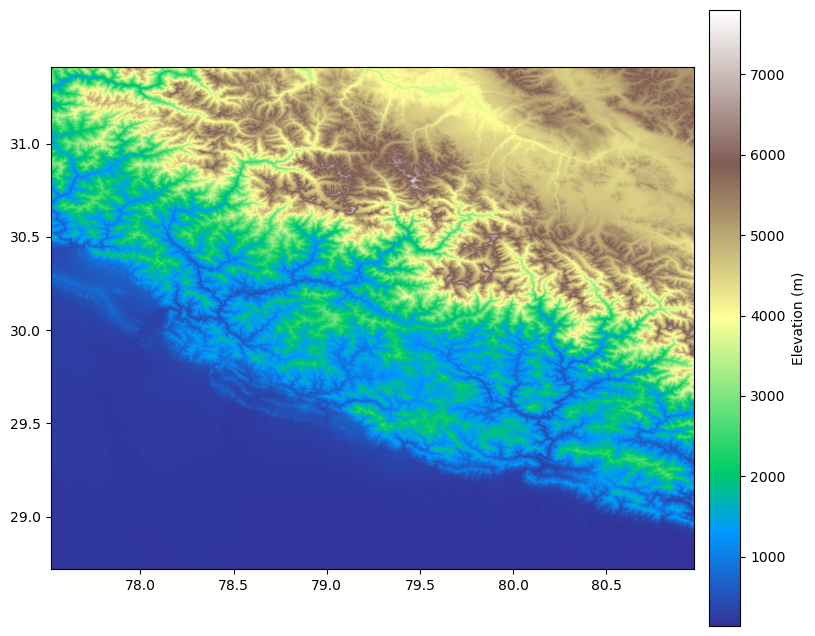

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.animation import FuncAnimation

# Function to convert DMS to decimal degrees
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# Function to check if a point is within the given distance from another point using the Haversine formula
def covers(point, target, distance):
    return haversine(point, target) <= distance

# Function to calculate the Haversine distance between two points in kilometers
def haversine(coord1, coord2):
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Earth radius in kilometers
    r = 6371.0
    return r * c

def is_within_elevation_range(center, terrain_data, bounds):
    lat_index = int((center[0] - bounds[0]) / terrain_data.res[0])
    lon_index = int((center[1] - bounds[2]) / terrain_data.res[1])
    
    # Debugging output
    # print(f"Computed indices: lat_index={lat_index}, lon_index={lon_index}")
    # print(f"Terrain data shape: {terrain_data.shape}")

    # Check if indices are within bounds
    if lat_index < 0 or lat_index >= terrain_data.shape[0] or lon_index < 0 or lon_index >= terrain_data.shape[1]:
        return False
    
    elevation = terrain_data.read(1)[lat_index, lon_index]
    return 0 <= elevation <= 2000

# Fitness function
def fitness(particle, data, distance, terrain_data, bounds):
    total_coverage = 0
    for point in data:
        for center in particle:
            if covers(center, point, distance):
                total_coverage += 1
                break
    return total_coverage

# PSO function
def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data):
    # Initialize particles
    particles = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=(num_particles, num_centers, 2))
    velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))

    # Ensure initial particles are within the elevation range
    for i in range(num_particles):
        for j in range(num_centers):
            while not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = np.array([fitness(p, data, distance, terrain_data, bounds) for p in particles])
    g_best = p_best[np.argmax(p_best_fitness)]
    g_best_fitness = np.max(p_best_fitness)

    # Initialize particle history
    particle_history = []

    # PSO iterations
    for iteration in range(num_iterations):
        for i in range(num_particles):
            print(iteration)
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], [bounds[0], bounds[2]], [bounds[1], bounds[3]])

            # Ensure particles are within the elevation range
            for j in range(num_centers):
                if not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                    particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

            # Update personal best
            current_fitness = fitness(particles[i], data, distance, terrain_data, bounds)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i]
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i]
                    g_best_fitness = current_fitness

        # Store particle positions for animation
        particle_history.append(particles.copy())

    # Return the best particles, best fitness, and particle history
    return g_best, g_best_fitness, particle_history

# # Function to check if a point is within the given distance from another point using Haversine formula
# def covers(point, target, distance):
#     return haversine(point, target) <= distance

# # Function to evaluate fitness of a particle
# def fitness(particle, data, distance, terrain_data, bounds):
#     total_coverage = 0
#     for point in data:
#         for center in particle:
#             if covers(center, point, distance):
#                 lat_index = int((point[0] - bounds[0]) / terrain_data.res[0])
#                 lon_index = int((point[1] - bounds[2]) / terrain_data.res[1])
#                 elevation = terrain_data.read(1)[lat_index, lon_index]
#                 if 0 <= elevation <= 2000:
#                     total_coverage += 1
#                     break
#     return total_coverage


# Define the PSO parameters
num_particles = 30  # Number of particles in the swarm
num_iterations = 1000  # Number of iterations to run the PSO
w = 0.5  # Inertia weight
c1 = 1.5  # Cognitive (particle) weight
c2 = 1.5  # Social (swarm) weight

# Define the bounds for the search space in decimal degrees
bounds = [
    min(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),
    max(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),  # Latitude bounds
    min(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E')),
    max(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E'))   # Longitude bounds
]

# Define the data points (converted to decimal degrees)
data = np.array([
    [dms_to_dd(30, 18, 40, 'N'), dms_to_dd(78, 2, 9, 'E')],
    [dms_to_dd(29, 56, 43, 'N'), dms_to_dd(78, 9, 4, 'E')],
    [dms_to_dd(29, 52, 43, 'N'), dms_to_dd(77, 53, 15, 'E')],
    [dms_to_dd(30, 13, 32, 'N'), dms_to_dd(78, 46, 58, 'E')],
    [dms_to_dd(30, 8, 42, 'N'), dms_to_dd(78, 45, 59, 'E')],
    [dms_to_dd(30, 24, 4, 'N'), dms_to_dd(78, 27, 51, 'E')],
    [dms_to_dd(30, 33, 44, 'N'), dms_to_dd(79, 33, 46, 'E')],
    [dms_to_dd(29, 34, 41, 'N'), dms_to_dd(79, 39, 23, 'E')],
    [dms_to_dd(29, 34, 24, 'N'), dms_to_dd(80, 15, 18, 'E')],
    [dms_to_dd(30, 46, 50, 'N'), dms_to_dd(79, 16, 23, 'E')],
    [dms_to_dd(31, 0, 38, 'N'), dms_to_dd(79, 3, 27, 'E')],
    [dms_to_dd(31, 6, 33, 'N'), dms_to_dd(78, 51, 35, 'E')],
    [dms_to_dd(31, 5, 9, 'N'), dms_to_dd(78, 35, 36, 'E')],
    [dms_to_dd(31, 1, 12, 'N'), dms_to_dd(78, 33, 7, 'E')]
])

# Set the distance for coverage in kilometers
distance = 50  # Assuming 50 km for the coverage radius

# Load the terrain data
terrain_file = "/Users/parasdhiman/Desktop/DRDO/output_SRTMGL1 2.tif"  # Replace with your actual file path
terrain_data = rasterio.open(terrain_file)

# Number of centers to find
num_centers = 6

# Find the best centers using PSO
best_points, _, particle_history = pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data)

# Create animation
fig, ax = plt.subplots(figsize=(10, 8))

# Show the terrain data with custom elevation-based colormap
terrain_image = ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')

# Add color bar for elevation
cbar = plt.colorbar(terrain_image, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Elevation (m)')

def update(frame):
    ax.clear()

    ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
    ax.scatter(data[:, 1], data[:, 0], c='white', label='Points')

    particles = particle_history[frame]
    for particle in particles:
        ax.scatter(particle[:, 1], particle[:, 0], c='blue', alpha=0.5)

    if frame == len(particle_history) - 1:
        for center in best_points:
            ax.scatter(center[1], center[0], c='red', marker='x', s=100, label='Center')
            circle = plt.Circle((center[1], center[0]), distance / 111, color='blue', fill=False)
            ax.add_artist(circle)

    ax.set_xlim(bounds[2], bounds[3])
    ax.set_ylim(bounds[0], bounds[1])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'PSO Optimization for Center Locations (Iteration {frame + 1}/{num_iterations})')

    cbar.set_label('Elevation (m)')

    ax.legend()




0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
1

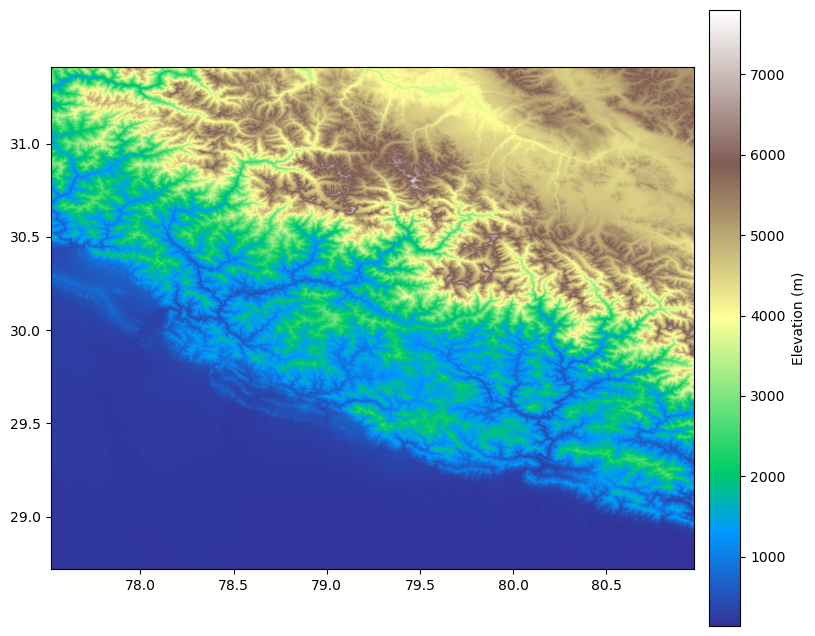

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.animation import FuncAnimation

# Function to convert DMS to decimal degrees
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# Function to check if a point is within the given distance from another point using the Haversine formula
def covers(point, target, distance):
    return haversine(point, target) <= distance

# Function to calculate the Haversine distance between two points in kilometers
def haversine(coord1, coord2):
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Earth radius in kilometers
    r = 6371.0
    return r * c

def is_within_elevation_range(center, terrain_data, bounds):
    lat_index = int((center[0] - bounds[0]) / terrain_data.res[0])
    lon_index = int((center[1] - bounds[2]) / terrain_data.res[1])

    # Check if indices are within bounds
    if lat_index < 0 or lat_index >= terrain_data.shape[0] or lon_index < 0 or lon_index >= terrain_data.shape[1]:
        return False
    
    elevation = terrain_data.read(1)[lat_index, lon_index]
    return 0 <= elevation <= 2000

# Fitness function
def fitness(particle, data, distance, terrain_data, bounds):
    total_coverage = 0
    for point in data:
        for center in particle:
            if covers(center, point, distance):
                total_coverage += 1
                break
    return total_coverage

# PSO function
def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data):
    # Initialize particles
    particles = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=(num_particles, num_centers, 2))
    velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))

    # Ensure initial particles are within the elevation range
    for i in range(num_particles):
        for j in range(num_centers):
            while not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = np.array([fitness(p, data, distance, terrain_data, bounds) for p in particles])
    g_best = p_best[np.argmax(p_best_fitness)]
    g_best_fitness = np.max(p_best_fitness)

    # Initialize particle history
    particle_history = []

    # PSO iterations
    for iteration in range(num_iterations):
        for i in range(num_particles):
            print(iteration)
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], [bounds[0], bounds[2]], [bounds[1], bounds[3]])

            # Ensure particles are within the elevation range
            for j in range(num_centers):
                if not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                    particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

            # Update personal best
            current_fitness = fitness(particles[i], data, distance, terrain_data, bounds)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i]
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i]
                    g_best_fitness = current_fitness

        # Store particle positions for animation
        particle_history.append(particles.copy())

    # Return the best particles, best fitness, and particle history
    return g_best, g_best_fitness, particle_history

# Define the PSO parameters
num_particles = 30  # Number of particles in the swarm
num_iterations = 100  # Number of iterations to run the PSO
w = 0.5  # Inertia weight
c1 = 1.5  # Cognitive (particle) weight
c2 = 1.5  # Social (swarm) weight

# Define the bounds for the search space in decimal degrees
bounds = [
    min(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),
    max(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),  # Latitude bounds
    min(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E')),
    max(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E'))   # Longitude bounds
]

# Define the data points (converted to decimal degrees)
data = np.array([
    [dms_to_dd(30, 18, 40, 'N'), dms_to_dd(78, 2, 9, 'E')],
    [dms_to_dd(29, 56, 43, 'N'), dms_to_dd(78, 9, 4, 'E')],
    [dms_to_dd(29, 52, 43, 'N'), dms_to_dd(77, 53, 15, 'E')],
    [dms_to_dd(30, 13, 32, 'N'), dms_to_dd(78, 46, 58, 'E')],
    [dms_to_dd(30, 8, 42, 'N'), dms_to_dd(78, 45, 59, 'E')],
    [dms_to_dd(30, 24, 4, 'N'), dms_to_dd(78, 27, 51, 'E')],
    [dms_to_dd(30, 33, 44, 'N'), dms_to_dd(79, 33, 46, 'E')],
    [dms_to_dd(29, 34, 41, 'N'), dms_to_dd(79, 39, 23, 'E')],
    [dms_to_dd(29, 34, 24, 'N'), dms_to_dd(80, 15, 18, 'E')],
    [dms_to_dd(30, 46, 50, 'N'), dms_to_dd(79, 16, 23, 'E')],
    [dms_to_dd(31, 0, 38, 'N'), dms_to_dd(79, 3, 27, 'E')],
    [dms_to_dd(31, 6, 33, 'N'), dms_to_dd(78, 51, 35, 'E')],
    [dms_to_dd(31, 5, 9, 'N'), dms_to_dd(78, 35, 36, 'E')],
    [dms_to_dd(31, 1, 12, 'N'), dms_to_dd(78, 33, 7, 'E')]
])

# Set the distance for coverage in kilometers
distance = 50  # Assuming 50 km for the coverage radius

# Load the terrain data
terrain_file = "/Users/parasdhiman/Desktop/DRDO/output_SRTMGL1 2.tif"  # Replace with your actual file path
terrain_data = rasterio.open(terrain_file)

# Number of centers to find
num_centers = 6

# Find the best centers
# Find the best centers using PSO
best_points, _, particle_history = pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data)

# Create animation
fig, ax = plt.subplots(figsize=(10, 8))

# Show the terrain data with custom elevation-based colormap
terrain_image = ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')

# Add color bar for elevation
cbar = plt.colorbar(terrain_image, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Elevation (m)')

def update(frame):
    ax.clear()

    ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
    ax.scatter(data[:, 1], data[:, 0], c='white', label='Points')

    particles = particle_history[frame]
    for particle in particles:
        ax.scatter(particle[:, 1], particle[:, 0], c='blue', alpha=0.5)

    if frame == len(particle_history) - 1:
        for center in best_points:
            ax.scatter(center[1], center[0], c='red', marker='x', s=100, label='Center')
            circle = plt.Circle((center[1], center[0]), distance / 111, color='blue', fill=False)
            ax.add_artist(circle)

    ax.set_xlim(bounds[2], bounds[3])
    ax.set_ylim(bounds[0], bounds[1])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'PSO Optimization for Center Locations (Iteration {frame + 1}/{num_iterations})')

    cbar.set_label('Elevation (m)')

    ax.legend()

# Create animation
# anim = FuncAnimation(fig, update, frames=len(particle_history), interval=200)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
1

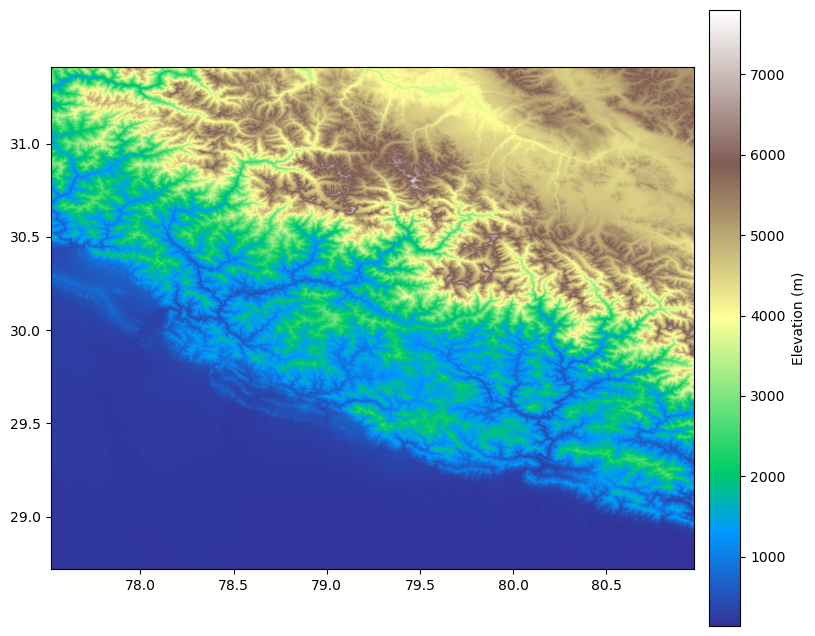

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.animation import FuncAnimation

# Function to convert DMS to decimal degrees
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# Function to check if a point is within the given distance from another point using the Haversine formula
def covers(point, target, distance):
    return haversine(point, target) <= distance

# Function to calculate the Haversine distance between two points in kilometers
def haversine(coord1, coord2):
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Earth radius in kilometers
    r = 6371.0
    return r * c

def is_within_elevation_range(center, terrain_data, bounds):
    lat_index = int((center[0] - bounds[0]) / terrain_data.res[0])
    lon_index = int((center[1] - bounds[2]) / terrain_data.res[1])

    # Check if indices are within bounds
    if lat_index < 0 or lat_index >= terrain_data.shape[0] or lon_index < 0 or lon_index >= terrain_data.shape[1]:
        return False
    
    elevation = terrain_data.read(1)[lat_index, lon_index]
    return 0 <= elevation <= 2000

# Fitness function
def fitness(particle, data, distance, terrain_data, bounds):
    total_coverage = 0
    covered_points = set()
    for point in data:
        for center in particle:
            if covers(center, point, distance):
                total_coverage += 1
                covered_points.add(tuple(point))
                break
    return total_coverage, covered_points

# PSO function
def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data):
    # Initialize particles
    particles = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=(num_particles, num_centers, 2))
    velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))

    # Ensure initial particles are within the elevation range
    for i in range(num_particles):
        for j in range(num_centers):
            while not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = [0] * num_particles  # Initialize as a list
    for i in range(num_particles):
        p_best_fitness[i], _ = fitness(p_best[i], data, distance, terrain_data, bounds)
    g_best_index = np.argmax(p_best_fitness)
    g_best = p_best[g_best_index].copy()
    g_best_fitness = p_best_fitness[g_best_index]
    g_best_covered = set()

    # Initialize particle history
    particle_history = [particles.copy()]
    centers_list = []
    points_covered_list = []

    # PSO iterations
    for iteration in range(num_iterations):
        all_covered = False
        
        for i in range(num_particles):
            print(iteration)
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], [bounds[0], bounds[2]], [bounds[1], bounds[3]])

            # Ensure particles are within the elevation range
            for j in range(num_centers):
                if not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                    particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

            # Update personal best
            current_fitness, current_covered = fitness(particles[i], data, distance, terrain_data, bounds)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i].copy()
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i].copy()
                    g_best_fitness = current_fitness
                    g_best_covered = current_covered.copy()
                    
                    # Check if all points are covered
                    if len(g_best_covered) == len(data):
                        all_covered = True
                        
            centers_list.append(num_centers)
            points_covered_list.append(len(g_best_covered))

        # Store particle positions for animation
        particle_history.append(particles.copy())
        
        # Terminate early if all points are covered
        if all_covered:
            break

    # Return the best particles, best fitness, and particle history
    return g_best, g_best_fitness, g_best_covered, particle_history, centers_list, points_covered_list

# Define the PSO parameters
num_particles = 30  # Number of particles in the swarm
num_iterations = 100  # Number of iterations to run the PSO
w = 0.5  # Inertia weight
c1 = 1.5  # Cognitive (particle) weight
c2 = 1.5  # Social (swarm) weight

# Define the bounds for the search space in decimal degrees
bounds = [
    min(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),
    max(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),  # Latitude bounds
    min(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E')),
    max(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E'))   # Longitude bounds
]

# Define the data points (converted to decimal degrees)
data = np.array([
    [dms_to_dd(30, 18, 40, 'N'), dms_to_dd(78, 2, 9, 'E')],
    [dms_to_dd(29, 56, 43, 'N'), dms_to_dd(78, 9, 4, 'E')],
    [dms_to_dd(29, 52, 43, 'N'), dms_to_dd(77, 53, 15, 'E')],
    [dms_to_dd(30, 13, 32, 'N'), dms_to_dd(78, 46, 58, 'E')],
    [dms_to_dd(30, 8, 42, 'N'), dms_to_dd(78, 45, 59, 'E')],
    [dms_to_dd(30, 24, 4, 'N'), dms_to_dd(78, 27, 51, 'E')],
    [dms_to_dd(30, 33, 44, 'N'), dms_to_dd(79, 33, 46, 'E')],
    [dms_to_dd(29, 34, 41, 'N'), dms_to_dd(79, 39, 23, 'E')],
    [dms_to_dd(29, 34, 24, 'N'), dms_to_dd(80, 15, 18, 'E')],
    [dms_to_dd(30, 46, 50, 'N'), dms_to_dd(79, 16, 23, 'E')],
    [dms_to_dd(31, 0, 38, 'N'), dms_to_dd(79, 3, 27, 'E')],
    [dms_to_dd(31, 6, 33, 'N'), dms_to_dd(78, 51, 35, 'E')],
    [dms_to_dd(31, 5, 9, 'N'), dms_to_dd(78, 35, 36, 'E')],
    [dms_to_dd(31, 1, 12, 'N'), dms_to_dd(78, 33, 7, 'E')]
])

# Set the distance for coverage in kilometers
distance = 50  # Assuming 50 km for the coverage radius

# Load the terrain data
terrain_file = "/Users/parasdhiman/Desktop/DRDO/output_SRTMGL1 2.tif"  # Replace with your actual file path
terrain_data = rasterio.open(terrain_file)

# Number of centers to find (vary this to see how many centers are needed to cover all points)
max_centers = 6

# Find the best centers using PSO
# best_points, _, _, particle_history = pso(data, bounds, distance, num_particles, num_iterations, max_centers, terrain_data)
best_points, _, _, particle_history, centers_list, points_covered_list = pso(data, bounds, distance, num_particles, num_iterations, max_centers, terrain_data)

# Animation setup
fig, ax = plt.subplots(figsize=(10, 8))
terrain_image = ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
cbar = plt.colorbar(terrain_image, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Elevation (m)')

def update(frame):
    ax.clear()
    ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
    ax.scatter(data[:, 1], data[:, 0], c='white', label='Points')
    
    particles = particle_history[frame]
    for particle in particles:
        ax.scatter(particle[:, 1], particle[:, 0], c='blue', alpha=0.5)
    
    if frame == len(particle_history) - 1:
        for center in best_points:
            ax.scatter(center[:, 1], center[:, 0], c='red', marker='x', s=100, label='Center')
            circle = plt.Circle((center[:, 1], center[:, 0]), distance / 111, color='blue', fill=False)
            ax.add_artist(circle)
    
    ax.set_xlim(bounds[2], bounds[3])
    ax.set_ylim(bounds[0], bounds[1])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'PSO Optimization for Center Locations (Iteration {frame + 1}/{len(particle_history)})')
    
    cbar.set_label('Elevation (m)')
    
    ax.legend()



In [33]:
import csv
# Save data to a CSV file
csv_file = 'centers_vs_points_covered5.csv'

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Number of Centers', 'Points Covered'])

    for centers, points_covered in zip(centers_list, points_covered_list):
        writer.writerow([centers, points_covered])

print(f"Data saved to '{csv_file}' successfully.")

Data saved to 'centers_vs_points_covered5.csv' successfully.


In [37]:
import pickle

# Define the file path to save the parameters
param_file_path = 'pso_params_6chc.pkl'


# Save the parametric information
with open(param_file_path, 'wb') as f:
    pickle.dump({
        'particle_history': particle_history,
        'bounds': bounds,
        'data': data,
        'best_points': best_points,
        'distance': distance
    }, f)


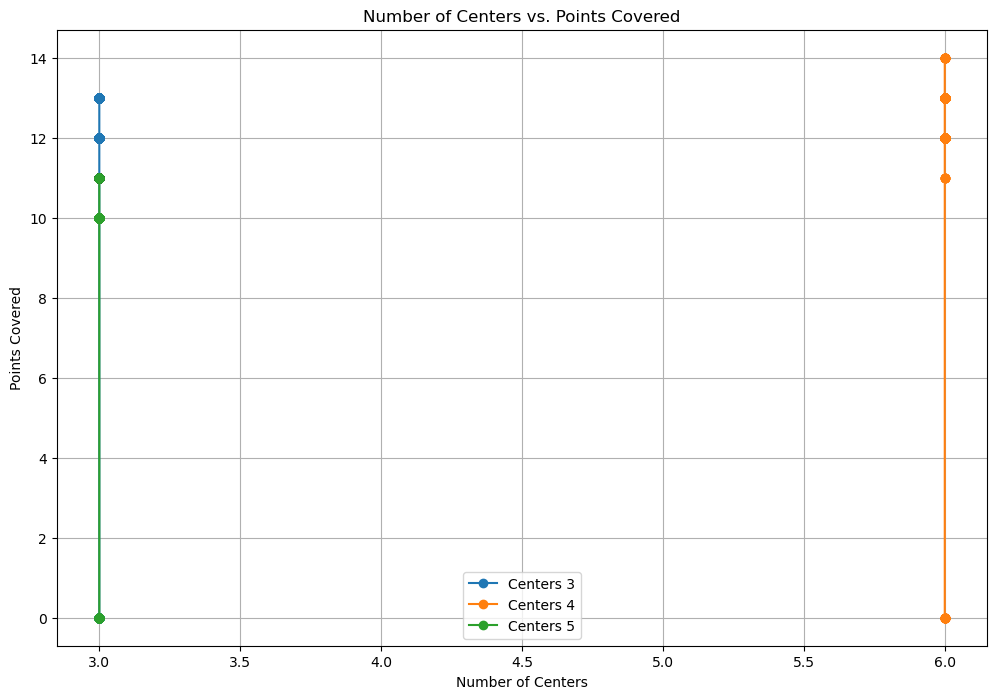

In [39]:
import csv
import matplotlib.pyplot as plt

# Function to read data from a CSV file
def read_csv_data(csv_file):
    centers = []
    points_covered = []
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header
        for row in reader:
            centers.append(int(row[0]))
            points_covered.append(int(row[1]))
    return centers, points_covered

# CSV files
csv_files = {
    'Centers 3': 'centers_vs_points_covered3.csv',
    'Centers 4': 'centers_vs_points_covered5.csv',
    'Centers 5': 'centers_vs_points_covered33.csv'
}

# Plotting the data
plt.figure(figsize=(12, 8))

for label, csv_file in csv_files.items():
    centers, points_covered = read_csv_data(csv_file)
    plt.plot(centers, points_covered, marker='o', linestyle='-', label=label)

plt.title('Number of Centers vs. Points Covered')
plt.xlabel('Number of Centers')
plt.ylabel('Points Covered')
plt.legend()
plt.grid(True)
plt.show()


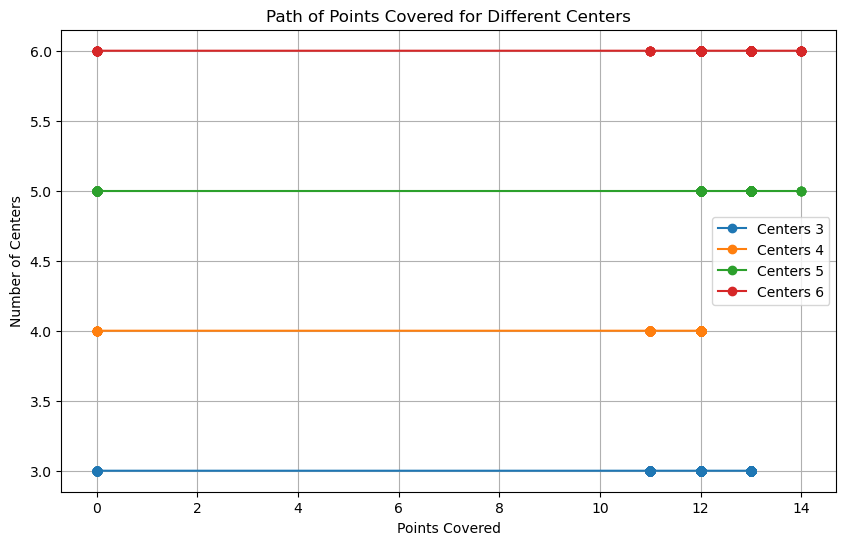

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
csv_files = {
    'Centers 3': 'centers_vs_points_covered3.csv',
    'Centers 4': 'centers_vs_points_covered4.csv',
    'Centers 5': 'centers_vs_points_covered5.csv',
    'Centers 6': 'centers_vs_points_covered6.csv'}

# Initialize a dictionary to hold dataframes
dataframes = {}

# Load data from CSV files
for key, file_path in csv_files.items():
    dataframes[key] = pd.read_csv(file_path)

# Plot the data
plt.figure(figsize=(10, 6))

for key, df in dataframes.items():
    plt.plot(df['Points Covered'], df['Number of Centers'], marker='o', label=key)

plt.ylabel('Number of Centers')
plt.xlabel('Points Covered')
plt.title('Path of Points Covered for Different Centers')
plt.legend()
plt.grid(True)
plt.show()


6.671322222222224
3.8313222222222225
1.707733333333333
1.8819555555555556
1.6198222222222223
0.7806555555555557
Early stopping at iteration 59 due to low variance in fitness values.


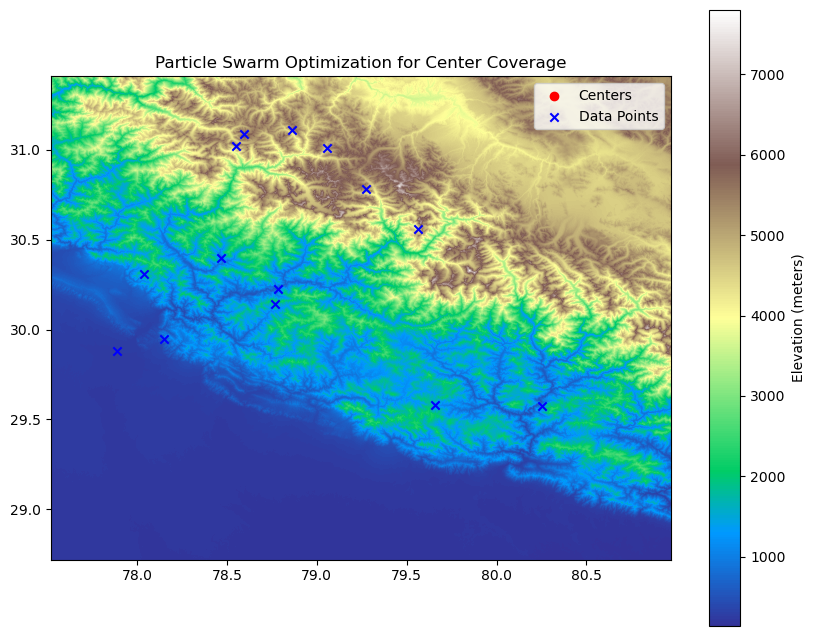

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.animation import FuncAnimation
import numpy as np
from scipy.spatial import KDTree

# Function to convert DMS to decimal degrees
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# Function to check if a point is within the given distance from another point using the Haversine formula
def covers(point, target, distance):
    return haversine(point, target) <= distance

# Function to calculate the Haversine distance between two points in kilometers
def haversine(coord1, coord2):
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Earth radius in kilometers
    r = 6371.0
    return r * c

def is_within_elevation_range(center, terrain_data, bounds):
    lat_index = int((center[0] - bounds[0]) / terrain_data.res[0])
    lon_index = int((center[1] - bounds[2]) / terrain_data.res[1])

    # Check if indices are within bounds
    if lat_index < 0 or lat_index >= terrain_data.shape[0] or lon_index < 0 or lon_index >= terrain_data.shape[1]:
        return False
    
    elevation = terrain_data.read(1)[lat_index, lon_index]
    return 0 <= elevation <= 2000

# Fitness function
def fitness(particle, data, distance, terrain_data, bounds):
    total_coverage = 0
    covered_points = set()
    for point in data:
        for center in particle:
            if covers(center, point, distance):
                total_coverage += 1
                covered_points.add(tuple(point))
                break
    return total_coverage, covered_points


# def fitness(particle, data, distance, terrain_data, bounds):
#     total_coverage = 0
#     covered_points = set()
    
#     # Create a KDTree for the data points for efficient neighbor search
#     data_tree = KDTree(data)

#     for center in particle:
#         indices = data_tree.query_ball_point(center, distance)
#         for idx in indices:
#             covered_points.add(tuple(data[idx]))

#     total_coverage = len(covered_points)
    
#     # Penalize for the number of clusters
#     penalty = -100 * 4

#     return total_coverage + penalty, covered_points



# def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data):
#     # Initialize particles
#     particles = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=(num_particles, num_centers, 2))
#     velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))

#     # Ensure initial particles are within the elevation range
#     for i in range(num_particles):
#         for j in range(num_centers):
#             while not is_within_elevation_range(particles[i, j], terrain_data, bounds):
#                 particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

#     # Initialize personal bests and global best
#     p_best = particles.copy()
#     p_best_fitness = [0] * num_particles
#     for i in range(num_particles):
#         p_best_fitness[i], _ = fitness(p_best[i], data, distance, terrain_data, bounds)
#     g_best_index = np.argmax(p_best_fitness)
#     g_best = p_best[g_best_index].copy()
#     g_best_fitness = p_best_fitness[g_best_index]
#     g_best_covered = set()

#     # Initialize particle history and fitness history
#     particle_history = [particles.copy()]
#     fitness_history = []
#     centers_list = []
#     points_covered_list = []

#     # PSO iterations
#     for iteration in range(num_iterations):
#         all_covered = False
#         current_fitness_values = []

#         for i in range(num_particles):
#             print(iteration)
#             # Update velocity
#             velocities[i] = (w * velocities[i]
#                              + c1 * np.random.rand() * (p_best[i] - particles[i])
#                              + c2 * np.random.rand() * (g_best - particles[i]))
#             # Update particle position
#             particles[i] += velocities[i]
#             # Boundary conditions
#             particles[i] = np.clip(particles[i], [bounds[0], bounds[2]], [bounds[1], bounds[3]])

#             # Ensure particles are within the elevation range
#             for j in range(num_centers):
#                 if not is_within_elevation_range(particles[i, j], terrain_data, bounds):
#                     particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

#             # Update personal best
#             current_fitness, current_covered = fitness(particles[i], data, distance, terrain_data, bounds)
#             current_fitness_values.append(current_fitness)
#             if current_fitness > p_best_fitness[i]:
#                 p_best[i] = particles[i].copy()
#                 p_best_fitness[i] = current_fitness

#                 # Update global best
#                 if current_fitness > g_best_fitness:
#                     g_best = particles[i].copy()
#                     g_best_fitness = current_fitness
#                     g_best_covered = current_covered.copy()
                    
#                     # Check if all points are covered
#                     if len(g_best_covered) == len(data):
#                         all_covered = True
                        
#             centers_list.append(num_centers)
#             points_covered_list.append(len(g_best_covered))

#         # Store particle positions for animation
#         particle_history.append(particles.copy())
#         fitness_history.append(current_fitness_values)
        
#         # Terminate early if all points are covered
#         if all_covered:
#             break

#         # Early stopping criterion based on variance of fitness values for the last 10 iterations
#         if (iteration >= 10 and iteration % 10 == 0):
#             last_10_fitness_values = [fitness_history[-j][i] for j in range(1, 11) for i in range(num_particles)]
#             fitness_variance = np.var(last_10_fitness_values)
#             print(fitness_variance)
#             if fitness_variance < threshold:  # Set an appropriate threshold)
#                 print(f"Early stopping at iteration {iteration} due to low variance in fitness values.")
#                 break

#     # Return the best particles, best fitness, and particle history
#     return g_best, g_best_fitness, g_best_covered, particle_history, centers_list, points_covered_list




# def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data, w=0.5, c1=1.5, c2=1.5, threshold=1e-3):
#     # Precompute bounds and elevation check parameters
#     bounds_low = np.array([bounds[0], bounds[2]])
#     bounds_high = np.array([bounds[1], bounds[3]])
    
#     def initialize_particles():
#         particles = np.random.uniform(low=bounds_low, high=bounds_high, size=(num_particles, num_centers, 2))
#         velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))
#         for i in range(num_particles):
#             for j in range(num_centers):
#                 while not is_within_elevation_range(particles[i, j], terrain_data, bounds):
#                     particles[i, j] = np.random.uniform(low=bounds_low, high=bounds_high, size=2)
#         return particles, velocities
    
#     # def is_within_elevation_range(center, terrain_data, bounds):
#     #     """Check if a center is within the elevation range of 0-2000 meters."""
#     #     row, col = terrain_data.index(center[1], center[0])
#     #     elevation = terrain_data.read(1)[row, col]
#     #     return 0 <= elevation <= 2000
    
#     # def fitness(particles, data, distance, terrain_data, bounds):
#     #     """Calculate the fitness of a particle."""
#     #     total_covered = set()
#     #     for center in particles:
#     #         covered = []
#     #         for point in data:
#     #             if np.linalg.norm(center - point) <= distance:
#     #                 covered.append(point)
#     #         total_covered.update(covered)
#     #     return len(total_covered), total_covered
    
#     # Initialize particles
#     particles, velocities = initialize_particles()

#     # Initialize personal bests and global best
#     p_best = particles.copy()
#     p_best_fitness = np.zeros(num_particles)
#     for i in range(num_particles):
#         p_best_fitness[i], _ = fitness(p_best[i], data, distance, terrain_data, bounds)
#     g_best_index = np.argmax(p_best_fitness)
#     g_best = p_best[g_best_index].copy()
#     g_best_fitness = p_best_fitness[g_best_index]
#     g_best_covered = set()

#     # Initialize particle history and fitness history
#     particle_history = [particles.copy()]
#     fitness_history = []
#     centers_list = []
#     points_covered_list = []

#     # PSO iterations
#     for iteration in range(num_iterations):
#         all_covered = False
#         current_fitness_values = []

#         for i in range(num_particles):
#             # Update velocity
#             velocities[i] = (w * velocities[i]
#                              + c1 * np.random.rand() * (p_best[i] - particles[i])
#                              + c2 * np.random.rand() * (g_best - particles[i]))
#             # Update particle position
#             particles[i] += velocities[i]
#             # Boundary conditions
#             particles[i] = np.clip(particles[i], bounds_low, bounds_high)

#             # Ensure particles are within the elevation range
#             for j in range(num_centers):
#                 if not is_within_elevation_range(particles[i, j], terrain_data, bounds):
#                     particles[i, j] = np.random.uniform(low=bounds_low, high=bounds_high, size=2)

#             # Update personal best
#             current_fitness, current_covered = fitness(particles[i], data, distance, terrain_data, bounds)
#             current_fitness_values.append(current_fitness)
#             if current_fitness > p_best_fitness[i]:
#                 p_best[i] = particles[i].copy()
#                 p_best_fitness[i] = current_fitness

#                 # Update global best
#                 if current_fitness > g_best_fitness:
#                     g_best = particles[i].copy()
#                     g_best_fitness = current_fitness
#                     g_best_covered = current_covered.copy()
                    
#                     # Check if all points are covered
#                     if len(g_best_covered) == len(data):
#                         all_covered = True
                        
#             centers_list.append(num_centers)
#             points_covered_list.append(len(g_best_covered))

#         # Store particle positions for animation
#         particle_history.append(particles.copy())
#         fitness_history.append(current_fitness_values)
        
#         # Terminate early if all points are covered
#         if all_covered:
#             break

#         # Early stopping criterion based on variance of fitness values for the last 10 iterations
#         if (iteration >= 10 and iteration % 10 == 0):
#             last_10_fitness_values = [fitness_history[-j][i] for j in range(1, 11) for i in range(num_particles)]
#             fitness_variance = np.var(last_10_fitness_values)
#             print(fitness_variance)
#             if fitness_variance < threshold:
#                 print(f"Early stopping at iteration {iteration} due to low variance in fitness values.")
#                 break

#     # Return the best particles, best fitness, and particle history
#     return g_best, g_best_fitness, g_best_covered, particle_history, centers_list, points_covered_list





import numpy as np

def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data, w=0.5, c1=1.5, c2=1.5, threshold=1.0):
    # Precompute bounds and elevation check parameters
    bounds_low = np.array([bounds[0], bounds[2]])
    bounds_high = np.array([bounds[1], bounds[3]])
    
    def initialize_particles():
        particles = np.random.uniform(low=bounds_low, high=bounds_high, size=(num_particles, num_centers, 2))
        velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))
        for i in range(num_particles):
            for j in range(num_centers):
                while not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                    particles[i, j] = np.random.uniform(low=bounds_low, high=bounds_high, size=2)
        return particles, velocities
    
    # def is_within_elevation_range(center, terrain_data, bounds):
    #     """Check if a center is within the elevation range of 0-2000 meters."""
    #     row, col = terrain_data.index(center[1], center[0])
    #     elevation = terrain_data.read(1)[row, col]
    #     return 0 <= elevation <= 2000
    
    # def fitness(particles, data, distance, terrain_data, bounds):
    #     """Calculate the fitness of a particle."""
    #     total_covered = set()
    #     for center in particles:
    #         covered = []
    #         for point in data:
    #             if np.linalg.norm(center - point) <= distance:
    #                 covered.append(point)
    #         total_covered.update(covered)
    #     return len(total_covered), total_covered
    
    # Initialize particles
    particles, velocities = initialize_particles()

    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = np.zeros(num_particles)
    for i in range(num_particles):
        p_best_fitness[i], _ = fitness(p_best[i], data, distance, terrain_data, bounds)
    g_best_index = np.argmax(p_best_fitness)
    g_best = p_best[g_best_index].copy()
    g_best_fitness = p_best_fitness[g_best_index]
    g_best_covered = set()

    # Initialize particle history and fitness history
    particle_history = [particles.copy()]
    fitness_history = []
    centers_list = []
    points_covered_list = []

    # PSO iterations
    for iteration in range(num_iterations):
        all_covered = False
        current_fitness_values = []

        for i in range(num_particles):
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], bounds_low, bounds_high)

            # Ensure particles are within the elevation range
            for j in range(num_centers):
                if not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                    particles[i, j] = np.random.uniform(low=bounds_low, high=bounds_high, size=2)

            # Update personal best
            current_fitness, current_covered = fitness(particles[i], data, distance, terrain_data, bounds)
            current_fitness_values.append(current_fitness)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i].copy()
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i].copy()
                    g_best_fitness = current_fitness
                    g_best_covered = current_covered.copy()
                    
                    # Check if all points are covered
                    if len(g_best_covered) == len(data):
                        all_covered = True

        # Store particle positions for animation
        particle_history.append(particles.copy())
        fitness_history.append(current_fitness_values)
        
        # Terminate early if all points are covered
        if all_covered:
            break

        # Early stopping criterion based on variance of fitness values for the last 10 iterations
        if iteration >= 9 and iteration % 10 == 9:
            last_10_fitness_values = [fitness_history[-j][i] for j in range(1, 11) for i in range(num_particles)]
            fitness_variance = np.var(last_10_fitness_values)
            print(fitness_variance)
            if fitness_variance < threshold:
                print(f"Early stopping at iteration {iteration} due to low variance in fitness values.")
                break

    # Return the best particles, best fitness, and particle history
    return g_best, g_best_fitness, g_best_covered, particle_history, centers_list, points_covered_list






# Define the PSO parameters
num_particles = 30  # Number of particles in the swarm
num_iterations = 100  # Number of iterations to run the PSO
w = 0.5  # Inertia weight
c1 = 1.5  # Cognitive (particle) weight
c2 = 1.5  # Social (swarm) weight
threshold = 1e-3  # Variance threshold for early stopping

# Define the bounds for the search space in decimal degrees
bounds = [
    min(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),
    max(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),  # Latitude bounds
    min(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E')),
    max(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E'))   # Longitude bounds
]

# Define the data points (converted to decimal degrees)
data = np.array([
    [dms_to_dd(30, 18, 40, 'N'), dms_to_dd(78, 2, 9, 'E')],
    [dms_to_dd(29, 56, 43, 'N'), dms_to_dd(78, 9, 4, 'E')],
    [dms_to_dd(29, 52, 43, 'N'), dms_to_dd(77, 53, 15, 'E')],
    [dms_to_dd(30, 13, 32, 'N'), dms_to_dd(78, 46, 58, 'E')],
    [dms_to_dd(30, 8, 42, 'N'), dms_to_dd(78, 45, 59, 'E')],
    [dms_to_dd(30, 24, 4, 'N'), dms_to_dd(78, 27, 51, 'E')],
    [dms_to_dd(30, 33, 44, 'N'), dms_to_dd(79, 33, 46, 'E')],
    [dms_to_dd(29, 34, 41, 'N'), dms_to_dd(79, 39, 23, 'E')],
    [dms_to_dd(29, 34, 24, 'N'), dms_to_dd(80, 15, 18, 'E')],
    [dms_to_dd(30, 46, 50, 'N'), dms_to_dd(79, 16, 23, 'E')],
    [dms_to_dd(31, 0, 38, 'N'), dms_to_dd(79, 3, 27, 'E')],
    [dms_to_dd(31, 6, 33, 'N'), dms_to_dd(78, 51, 35, 'E')],
    [dms_to_dd(31, 5, 9, 'N'), dms_to_dd(78, 35, 36, 'E')],
    [dms_to_dd(31, 1, 12, 'N'), dms_to_dd(78, 33, 7, 'E')]
])

# Set the distance for coverage in kilometers
distance = 50  # Assuming 50 km for the coverage radius

# Load the terrain data
terrain_file = "/Users/parasdhiman/Desktop/DRDO/output_SRTMGL1 2.tif"  # Replace with your actual file path
terrain_data = rasterio.open(terrain_file)

# Number of centers to find (vary this to see how many centers are needed to cover all points)
max_centers = 3


# Find the best centers using PSO
best_points, _, _, particle_history, centers_list, points_covered_list = pso(data, bounds, distance, num_particles, num_iterations, max_centers, terrain_data)

# Animation setup
fig, ax = plt.subplots(figsize=(10, 8))
terrain_image = ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
cbar = plt.colorbar(terrain_image, ax=ax)
cbar.set_label('Elevation (meters)')
ax.set_title('Particle Swarm Optimization for Center Coverage')
scat = ax.scatter([], [], color='red', marker='o', label='Centers')
ax.scatter(data[:, 1], data[:, 0], color='blue', marker='x', label='Data Points')
ax.legend()

def init():
    scat.set_offsets([])
    return scat,

def update(frame):
    ax.clear()
    ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
    ax.scatter(data[:, 1], data[:, 0], c='white', label='Points')
    
    particles = particle_history[frame]
    for particle in particles:
        ax.scatter(particle[:, 1], particle[:, 0], c='blue', alpha=0.5)
    
    if frame == len(particle_history) - 1:
        for center in best_points:
            ax.scatter(center[:, 1], center[:, 0], c='red', marker='x', s=100, label='Center')
            circle = plt.Circle((center[:, 1], center[:, 0]), distance / 111, color='blue', fill=False)
            ax.add_artist(circle)
    
    ax.set_xlim(bounds[2], bounds[3])
    ax.set_ylim(bounds[0], bounds[1])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'PSO Optimization for Center Locations (Iteration {frame + 1}/{len(particle_history)})')
    
    cbar.set_label('Elevation (m)')
    
    ax.legend()




(-179.99999999999991, -89.99999999999994, 180.0, 83.63410065300008)
start
particle init
gbest p best
inside pso last
iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Early stopping at iteration 9 due to low variance in fitness values.


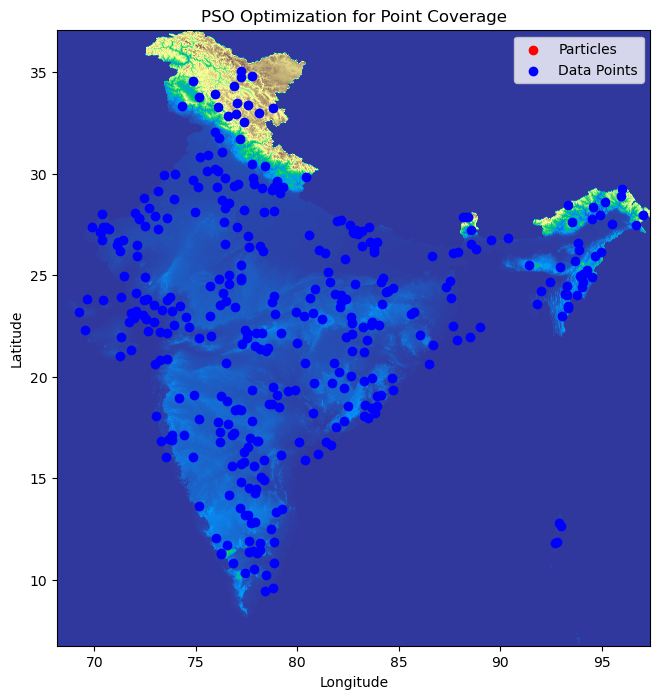

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.animation import FuncAnimation
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Function to convert DMS to decimal degrees
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# Function to check if a point is within the given distance from another point using the Haversine formula
def covers(point, target, distance):
    return haversine(point, target) <= distance

# Function to calculate the Haversine distance between two points in kilometers
def haversine(coord1, coord2):
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Earth radius in kilometers
    r = 6371.0
    return r * c

# Function to check if a point is within the elevation range
def is_within_elevation_range(center, terrain_data, bounds):
    lat_index = int((center[0] - bounds[0]) / terrain_data.res[0])
    lon_index = int((center[1] - bounds[2]) / terrain_data.res[1])

    if lat_index < 0 or lat_index >= terrain_data.shape[0] or lon_index < 0 or lon_index >= terrain_data.shape[1]:
        return False
    
    elevation = terrain_data.read(1)[lat_index, lon_index]
    return 0 <= elevation <= 2000

# Function to convert points to CSV
def save_points_to_csv(points, filename):
    np.savetxt(filename, points, delimiter=',', header='Latitude,Longitude', comments='')

# Fitness function to evaluate coverage
def fitness(particle, data, distance, terrain_data, bounds):
    total_coverage = 0
    covered_points = set()
    for point in data:
        for center in particle:
            if covers(center, point, distance):
                total_coverage += 1
                covered_points.add(tuple(point))
                break
    return total_coverage, covered_points

# PSO optimization function
def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data, w=0.5, c1=1.5, c2=1.5, threshold=1e-3):
    # Precompute bounds and elevation check parameters
    bounds_low = np.array([bounds[0], bounds[2]])
    bounds_high = np.array([bounds[1], bounds[3]])
    print("particle init")
    # def initialize_particles():
    #     particles = np.random.uniform(low=bounds_low, high=bounds_high, size=(num_particles, num_centers, 2))
    #     velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))
    #     for i in range(num_particles):
    #         for j in range(num_centers):
    #             while not is_within_elevation_range(particles[i, j], terrain_data, bounds):
    #                 particles[i, j] = np.random.uniform(low=bounds_low, high=bounds_high, size=2)
    #     return particles, velocities
    # def initialize_particles():
    #     particles = np.random.uniform(low=bounds_low, high=bounds_high, size=(num_particles, num_centers, 2))
    #     velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))
        
    #     # Reshape particles for easier vectorized operations
    #     particles_reshaped = particles.reshape(-1, 2)
        
    #     # Vectorized check for elevation range
    #     def is_within_elevation_range_batch(particles_batch):
    #         return np.array([is_within_elevation_range(p, terrain_data, bounds) for p in particles_batch])

    #     # Check initial particles
    #     valid_mask = is_within_elevation_range_batch(particles_reshaped)
        
    #     # While there are invalid particles, re-sample
    #     while not np.all(valid_mask):
    #         invalid_indices = np.where(~valid_mask)[0]
    #         particles_reshaped[invalid_indices] = np.random.uniform(low=bounds_low, high=bounds_high, size=(len(invalid_indices), 2))
    #         valid_mask = is_within_elevation_range_batch(particles_reshaped)
        
    #     # Reshape back to original shape
    #     particles = particles_reshaped.reshape(num_particles, num_centers, 2)
        
    #     return particles, velocities
    
    
    
    def initialize_particles():
        particles = np.random.uniform(low=bounds_low, high=bounds_high, size=(num_particles, num_centers, 2))
        velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))
        
        return particles, velocities
    
    # Initialize particles
    particles, velocities = initialize_particles()

    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = np.zeros(num_particles)
    
    print("gbest p best")
   
    for i in range(num_particles):
        p_best_fitness[i], _ = fitness(p_best[i], data, distance, terrain_data, bounds)
    g_best_index = np.argmax(p_best_fitness)
    g_best = p_best[g_best_index].copy()
    g_best_fitness = p_best_fitness[g_best_index]
    g_best_covered = set()

    # Initialize particle history and fitness history
    particle_history = [particles.copy()]
    fitness_history = []
    centers_list = []
    points_covered_list = []
    print("inside pso last")
    # PSO iterations
    for iteration in range(num_iterations):
        print("iteration",iteration)
        all_covered = False
        current_fitness_values = []

        for i in range(num_particles):
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], bounds_low, bounds_high)

            # Ensure particles are within the elevation range
            for j in range(num_centers):
                if not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                    particles[i, j] = np.random.uniform(low=bounds_low, high=bounds_high, size=2)

            # Update personal best
            current_fitness, current_covered = fitness(particles[i], data, distance, terrain_data, bounds)
            current_fitness_values.append(current_fitness)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i].copy()
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i].copy()
                    g_best_fitness = current_fitness
                    g_best_covered = current_covered.copy()
                    
                    # Check if all points are covered
                    if len(g_best_covered) == len(data):
                        all_covered = True

        # Store particle positions for animation
        particle_history.append(particles.copy())
        fitness_history.append(current_fitness_values)
        
        # Terminate early if all points are covered
        if all_covered:
            break

        # Early stopping criterion based on variance of fitness values for the last 10 iterations
        if iteration >= 9 and iteration % 10 == 9:
            last_10_fitness_values = [fitness_history[-j][i] for j in range(1, 11) for i in range(num_particles)]
            fitness_variance = np.var(last_10_fitness_values)
            if fitness_variance < threshold:
                print(f"Early stopping at iteration {iteration} due to low variance in fitness values.")
                break

    # Return the best particles, best fitness, and particle history
    return g_best, g_best_fitness, g_best_covered, particle_history, centers_list, points_covered_list

# Function to load data points from CSV
def load_points_from_csv(filename):
    points = np.loadtxt(filename, delimiter=',', skiprows=1)
    return points

def load_india_boundaries(shapefile_path):
    """
    Load India's boundaries from a shapefile.

    Parameters:
    - shapefile_path (str): Path to the shapefile containing India's boundaries.

    Returns:
    - india_bounds (shapely.geometry.Polygon): Boundary polygon for India.
    """
    # Load shapefile into a GeoDataFrame
    gdf = gpd.read_file(shapefile_path)

    # Filter for India's boundary
    india_boundary = gdf[gdf['ADMIN'] == 'India'].geometry.iloc[0]

    return india_boundary

# Function to load boundaries of India using a shapefile
def load_india_boundaries(shapefile):
    india = gpd.read_file(shapefile)
    india = india.to_crs(epsg=4326)  # Ensure coordinates are in decimal degrees (WGS84)
    india_polygon = india.geometry.unary_union
    return india_polygon.bounds

# Example usage
if __name__ == "__main__":
    # Define the PSO parameters
    num_particles = 50  # Number of particles in the swarm
    num_iterations = 100  # Number of iterations to run the PSO
    w = 0.5  # Inertia weight
    c1 = 1.5  # Cognitive (particle) weight
    c2 = 1.5  # Social (swarm) weight
    threshold = 1e-3  # Variance threshold for early stopping

    # Define the boundaries of India using a shapefile
    india_shapefile = "/Users/parasdhiman/Desktop/DRDO/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"  # Replace with actual path to shapefile
    india_bounds = load_india_boundaries(india_shapefile)

    # Example usage: Print the boundary
    print(india_bounds)

    # Define the data points by loading from CSV
    data_csv_file = "/Users/parasdhiman/Desktop/DRDO/random_points_inside.csv"  # Replace with actual path
    data = load_points_from_csv(data_csv_file)

    # Define the distance threshold in kilometers
    distance = 50.0

    # Load terrain data using Rasterio (example terrain data loading, adjust as per your data)
    terrain_file = "/Users/parasdhiman/Desktop/DRDO/india_clipped.tif"  # Replace with actual path
    terrain_data = rasterio.open(terrain_file)
    num_center = 10
    print("start")
    # Run PSO optimization
    best_centers, best_fitness, best_covered, particle_history, centers_list, points_covered_list = pso(
        data, india_bounds, distance, num_particles, num_iterations, num_center, terrain_data, w, c1, c2, threshold)

    # Save best centers to CSV
    save_points_to_csv(best_centers, "best_centers.csv")

    # Plotting and animation
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title('PSO Optimization for Point Coverage')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Plot terrain data
    show(terrain_data, ax=ax, cmap='terrain')

    # Initialize scatter plot for particles
    scatter = ax.scatter([], [], c='red', label='Particles')

    # Initialize scatter plot for data points
    data_scatter = ax.scatter(data[:, 1], data[:, 0], c='blue', label='Data Points')

    # Update function for animation
    def update(frame):
        particles = particle_history[frame]
        scatter.set_offsets(particles.reshape(-1, 2))
        return scatter,

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(particle_history), interval=200, blit=True)

    # Show legend
    ax.legend()

    # Show plot
    plt.show()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.animation import FuncAnimation
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Function to convert DMS to decimal degrees
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# Function to check if a point is within the given distance from another point using the Haversine formula
def covers(point, target, distance):
    return haversine(point, target) <= distance

# Function to calculate the Haversine distance between two points in kilometers
def haversine(coord1, coord2):
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Earth radius in kilometers
    r = 6371.0
    return r * c

# Function to convert points to CSV
def save_points_to_csv(points, filename):
    np.savetxt(filename, points, delimiter=',', header='Latitude,Longitude', comments='')

# Fitness function to evaluate coverage
def fitness(particle, data, distance, terrain_data, bounds):
    total_coverage = 0
    covered_points = set()
    for point in data:
        for center in particle:
            if covers(center, point, distance):
                total_coverage += 1
                covered_points.add(tuple(point))
                break
    return total_coverage, covered_points

# Function to randomly generate particles within India's boundaries
def random_particles_within_india(india_polygon, num_particles):
    particles = []
    while len(particles) < num_particles:
        # Generate a candidate point within bounding box
        minx, miny, maxx, maxy = india_polygon.bounds
        candidate_point = [np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)]
        
        # Check if the point is within the India polygon
        if india_polygon.contains(Point(candidate_point)):
            particles.append(candidate_point)
    
    return np.array(particles)

# Updated initialize_particles function using random_particles_within_india
def initialize_particles(bounds, india_polygon, num_particles, num_centers):
    required_particles = num_particles * num_centers

    # Generate particles within India's boundaries
    particles = random_particles_within_india(india_polygon, required_particles)

    # Reshape particles and generate random velocities
    particles = particles.reshape(num_particles, num_centers, 2)
    velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))

    return particles, velocities



# PSO optimization function
def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data, india_polygon, w=0.5, c1=1.5, c2=1.5, threshold=1e-3):
    # Initialize particles
    print("the start particle for")
    particles, velocities = initialize_particles(bounds, india_polygon, num_particles, num_centers)
    print("check")
    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = np.zeros(num_particles)
    
    for i in range(num_particles):
        p_best_fitness[i], _ = fitness(p_best[i], data, distance, terrain_data, bounds)
    g_best_index = np.argmax(p_best_fitness)
    g_best = p_best[g_best_index].copy()
    g_best_fitness = p_best_fitness[g_best_index]
    g_best_covered = set()

    # Initialize particle history and fitness history
    particle_history = [particles.copy()]
    fitness_history = []
    centers_list = []
    points_covered_list = []
    print("particles initialised")

    # PSO iterations
    for iteration in range(num_iterations):
        all_covered = False
        current_fitness_values = []
        print("iteration",iteration)

        for i in range(num_particles):
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], [bounds[0], bounds[2]], [bounds[1], bounds[3]])

            # Ensure particles are within India's boundaries
            for j in range(num_centers):
                if not india_polygon.contains(Point(particles[i, j])):
                    particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)
                    while not india_polygon.contains(Point(particles[i, j])):
                        particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

            # Update personal best
            current_fitness, current_covered = fitness(particles[i], data, distance, terrain_data, bounds)
            current_fitness_values.append(current_fitness)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i].copy()
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i].copy()
                    g_best_fitness = current_fitness
                    g_best_covered = current_covered.copy()
                    
                    # Check if all points are covered
                    if len(g_best_covered) == len(data):
                        all_covered = True

        # Store particle positions for animation
        particle_history.append(particles.copy())
        fitness_history.append(current_fitness_values)
        
        # Terminate early if all points are covered
        if all_covered:
            break

        # Early stopping criterion based on variance of fitness values for the last 10 iterations
        if iteration >= 9 and iteration % 10 == 9:
            last_10_fitness_values = [fitness_history[-j][i] for j in range(1, 11) for i in range(num_particles)]
            fitness_variance = np.var(last_10_fitness_values)
            if fitness_variance < threshold:
                print(f"Early stopping at iteration {iteration} due to low variance in fitness values.")
                break

    # Return the best particles, best fitness, and particle history
    return g_best, g_best_fitness, g_best_covered, particle_history, centers_list, points_covered_list

# Function to load data points from CSV
def load_points_from_csv(filename):
    points = np.loadtxt(filename, delimiter=',', skiprows=1)
    return points

# Function to load boundaries of India using a shapefile
def load_india_boundaries(shapefile_path):
    india = gpd.read_file(shapefile_path)
    india = india.to_crs(epsg=4326)  # Ensure coordinates are in decimal degrees (WGS84)
    india_polygon = india.geometry.unary_union
    return india_polygon

# Example usage
if __name__ == "__main__":
    # Define the PSO parameters
    num_particles = 50  # Number of particles in the swarm
    num_iterations = 100  # Number of iterations to run the PSO
    w = 0.5  # Inertia weight
    c1 = 1.5  # Cognitive (particle) weight
    c2 = 1.5  # Social (swarm) weight
    threshold = 1e-3  # Variance threshold for early stopping

    # Define the boundaries of India using a shapefile
    india_shapefile = "/Users/parasdhiman/Desktop/DRDO/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"  # Replace with actual path to shapefile
    india_polygon = load_india_boundaries(india_shapefile)
    india_bounds = india_polygon.bounds

    # Example usage: Print the boundary
    print(india_bounds)

    # Define the data points by loading from CSV
    data_csv_file = "/Users/parasdhiman/Desktop/DRDO/random_points_inside.csv"  # Replace with actual path
    data = load_points_from_csv(data_csv_file)

    # Define the distance threshold in kilometers
    distance = 50.0

    # Load terrain data using Rasterio (example terrain data loading, adjust as per your data)
    terrain_file = "/Users/parasdhiman/Desktop/DRDO/india_clipped.tif"  # Replace with actual path
    terrain_data = rasterio.open(terrain_file)
    num_center = 10
    print("start")
    # Run PSO optimization
    best_centers, best_fitness, best_covered, particle_history, centers_list, points_covered_list = pso(
        data, india_bounds, distance, num_particles, num_iterations, num_center, terrain_data, india_polygon, w, c1, c2, threshold)

    # Save best centers to CSV
    save_points_to_csv(best_centers, "best_centers.csv")

    # Plotting and animation
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title('PSO Optimization for Point Coverage')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Plot terrain data
    show(terrain_data, ax=ax, cmap='terrain')

    # Initialize scatter plot for particles
    scatter = ax.scatter([], [], c='red', label='Particles')

    # Initialize scatter plot for data points
    data_scatter = ax.scatter(data[:, 1], data[:, 0], c='blue', label='Data Points')

    # Update function for animation
    def update(frame):
        particles = particle_history[frame]
        scatter.set_offsets(particles.reshape(-1, 2))
        return scatter,

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(particle_history), interval=200, blit=True)

    # Show legend
    ax.legend()

    # Show plot
    plt.show()


(-179.99999999999991, -89.99999999999994, 180.0, 83.63410065300008)
start
the start particle for
check
particles initialised
iteration 0


KeyboardInterrupt: 

In [18]:
import pickle

# Define the file path to save the parameters
param_file_path = 'pso_params_India.pkl'


# Save the parametric information
with open(param_file_path, 'wb') as f:
    pickle.dump({
        'particle_history': particle_history,
        'bounds': india_bounds,
        'data': data,
        'best_points': best_centers,
        'distance': distance
    }, f)

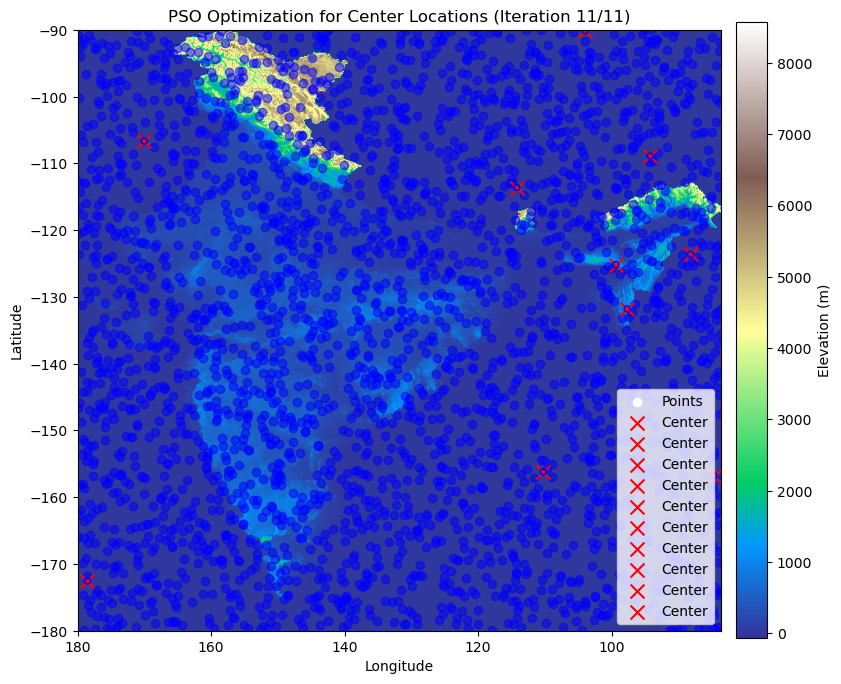

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from matplotlib.animation import FuncAnimation
import pickle

# Define the file path to load the parameters
param_file_path = 'pso_params_India.pkl'

# Load the parametric information
with open(param_file_path, 'rb') as f:
    params = pickle.load(f)

particle_history = params['particle_history']
bounds = params['bounds']
data = params['data']
best_points = params['best_points']
distance = params['distance']

# Load the terrain data
terrain_file = "/Users/parasdhiman/Desktop/DRDO/india_clipped.tif"  # Replace with your actual file path
terrain_data = rasterio.open(terrain_file)

# Create animation
fig, ax = plt.subplots(figsize=(10, 8))

# Show the terrain data with custom elevation-based colormap
terrain_image = ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')

# Add color bar for elevation
cbar = plt.colorbar(terrain_image, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Elevation (m)')

def update(frame):
    ax.clear()
    ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
    ax.scatter(data[:, 1], data[:, 0], c='white', label='Points')

    particles = particle_history[frame]
    for particle in particles:
        ax.scatter(particle[:, 1], particle[:, 0], c='blue', alpha=0.5)

    if frame == len(particle_history) - 1:
        for center in best_points:
            ax.scatter(center[1], center[0], c='red', marker='x', s=100, label='Center')
            circle = plt.Circle((center[1], center[0]), distance / 111, color='blue', fill=False)
            ax.add_artist(circle)

    ax.set_xlim(bounds[2], bounds[3])
    ax.set_ylim(bounds[0], bounds[1])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'PSO Optimization for Center Locations (Iteration {frame + 1}/{len(particle_history)})')

    cbar.set_label('Elevation (m)')

    ax.legend()

# Animate the PSO process
ani = FuncAnimation(fig, update, frames=len(particle_history), interval=200)
ani.save('pso_optimization_india.mp4', writer='ffmpeg', fps=10) 

# Show the animation
# plt.show()



In [11]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

# Function to load boundaries of India using a shapefile
def load_india_boundaries(shapefile_path):
    india = gpd.read_file(shapefile_path)
    india = india.to_crs(epsg=4326)  # Ensure coordinates are in decimal degrees (WGS84)
    india_polygon = india.geometry.unary_union
    return india_polygon

# Function to randomly generate particles within India's boundaries
def random_particles_within_india(india_polygon, num_particles):
    particles = []
    while len(particles) < num_particles:
        # Generate a candidate point within bounding box
        minx, miny, maxx, maxy = india_polygon.bounds
        candidate_point = [np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)]
        
        # Check if the point is within the India polygon
        if india_polygon.contains(Point(candidate_point)):
            particles.append(candidate_point)
    
    return np.array(particles)

# Test function to verify the initialization
def test_random_particles_within_india():
    india_shapefile = "/Users/parasdhiman/Desktop/DRDO/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
    india_polygon = load_india_boundaries(india_shapefile)

    num_particles = 50

    particles = random_particles_within_india(india_polygon, num_particles)
    print(f"Particles shape: {particles.shape}")
    print(f"First few particles: {particles[:5]}")

test_random_particles_within_india()


Particles shape: (500, 2)
First few particles: [[-96.71775389 -79.07585124]
 [ 60.51917278 -83.98337409]
 [141.59631911  67.43933544]
 [-67.24199808 -10.53063122]
 [-90.70854695  33.85392342]]


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.animation import FuncAnimation
import geopandas as gpd
from shapely.geometry import Point

# Function to convert points to CSV
def save_points_to_csv(points, filename):
    np.savetxt(filename, points, delimiter=',', header='Latitude,Longitude', comments='')

# Fitness function to evaluate coverage
def fitness(particle, data, distance, terrain_data, bounds):
    total_coverage = 0
    covered_points = set()
    for point in data:
        for center in particle:
            if covers(center, point, distance):
                total_coverage += 1
                covered_points.add(tuple(point))
                break
    return total_coverage, covered_points

# Function to randomly generate particles within India's boundaries
def random_particles_within_india(india_polygon, num_particles):
    particles = []
    while len(particles) < num_particles:
        # Generate a candidate point within bounding box
        minx, miny, maxx, maxy = india_polygon.bounds
        candidate_point = [np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)]
        
        # Check if the point is within the India polygon
        if india_polygon.contains(Point(candidate_point)):
            particles.append(candidate_point)
    
    return np.array(particles)

# PSO optimization function
def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data, india_polygon, w=0.5, c1=1.5, c2=1.5, threshold=1e-3):
    # Initialize particles
    print("before init")
    particles = random_particles_within_india(india_polygon, num_particles * num_centers)
    particles = particles.reshape(num_particles, num_centers, 2)
    velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))

    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = np.zeros(num_particles)
    
    for i in range(num_particles):
        p_best_fitness[i], _ = fitness(p_best[i], data, distance, terrain_data, bounds)
    g_best_index = np.argmax(p_best_fitness)
    g_best = p_best[g_best_index].copy()
    g_best_fitness = p_best_fitness[g_best_index]
    g_best_covered = set()

    # Initialize particle history and fitness history
    particle_history = [particles.copy()]
    fitness_history = []
    print("check after particle init")

    # PSO iterations
    for iteration in range(num_iterations):
        print(iteration)
        all_covered = False
        current_fitness_values = []
        print("here1")
        for i in range(num_particles):
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], [bounds[0], bounds[2]], [bounds[1], bounds[3]])

            # Ensure particles are within India's boundaries
            for j in range(num_centers):
                while not india_polygon.contains(Point(particles[i, j])):
                    particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)
            print("here2")
            # Update personal best
            current_fitness, current_covered = fitness(particles[i], data, distance, terrain_data, bounds)
            current_fitness_values.append(current_fitness)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i].copy()
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i].copy()
                    g_best_fitness = current_fitness
                    g_best_covered = current_covered.copy()
                    
                    # Check if all points are covered
                    if len(g_best_covered) == len(data):
                        all_covered = True
        print("here3")
        # Store particle positions for animation
        particle_history.append(particles.copy())
        fitness_history.append(current_fitness_values)
        
        # Terminate early if all points are covered
        if all_covered:
            break

        # Early stopping criterion based on variance of fitness values for the last 10 iterations
        if iteration >= 9 and iteration % 10 == 9:
            last_10_fitness_values = [fitness_history[-j][i] for j in range(1, 11) for i in range(num_particles)]
            fitness_variance = np.var(last_10_fitness_values)
            if fitness_variance < threshold:
                print(f"Early stopping at iteration {iteration} due to low variance in fitness values.")
                break
        print("here4")

    # Return the best particles, best fitness, and particle history
    return g_best, g_best_fitness, g_best_covered, particle_history

# Function to load data points from CSV
def load_points_from_csv(filename):
    points = np.loadtxt(filename, delimiter=',', skiprows=1)
    return points

# Function to load boundaries of India using a shapefile
def load_india_boundaries(shapefile_path):
    india = gpd.read_file(shapefile_path)
    india = india.to_crs(epsg=4326)  # Ensure coordinates are in decimal degrees (WGS84)
    india_polygon = india.geometry.unary_union
    return india_polygon

# Example usage
if __name__ == "__main__":
    # Define the PSO parameters
    num_particles = 50  # Number of particles in the swarm
    num_iterations = 100  # Number of iterations to run the PSO
    w = 0.5  # Inertia weight
    c1 = 1.5  # Cognitive (particle) weight
    c2 = 1.5  # Social (swarm) weight
    threshold = 1e-3  # Variance threshold for early stopping

    # Define the boundaries of India using a shapefile
    india_shapefile = "/Users/parasdhiman/Desktop/DRDO/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"  # Replace with actual path to shapefile
    india_polygon = load_india_boundaries(india_shapefile)
    india_bounds = india_polygon.bounds

    # Define the data points by loading from CSV
    data_csv_file = "/Users/parasdhiman/Desktop/DRDO/random_points_inside.csv"  # Replace with actual path
    data = load_points_from_csv(data_csv_file)

    # Define the distance threshold in kilometers
    distance = 50.0

    # Load terrain data using Rasterio (example terrain data loading, adjust as per your data)
    terrain_file = "/Users/parasdhiman/Desktop/DRDO/india_clipped.tif"  # Replace with actual path
    terrain_data = rasterio.open(terrain_file)

    # Run PSO optimization
    best_centers, best_fitness, best_covered, particle_history = pso(
        data, india_bounds, distance, num_particles, num_iterations, num_centers=10, terrain_data=terrain_data, india_polygon=india_polygon, w=w, c1=c1, c2=c2, threshold=threshold)

    # Save best centers to CSV
    save_points_to_csv(best_centers, "best_centers.csv")

    # Plotting and animation
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title('PSO Optimization for Point Coverage')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Plot terrain data
    show(terrain_data, ax=ax, cmap='terrain')

    # Initialize scatter plot for particles
    scatter = ax.scatter([], [], c='red', label='Particles')

    # Initialize scatter plot for data points
    data_scatter = ax.scatter(data[:, 1], data[:, 0], c='blue', label='Data Points')

    # Update function for animation
    def update(frame):
        particles = particle_history[frame]
        scatter.set_offsets(particles.reshape(-1, 2))
        return scatter,

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(particle_history), interval=200, blit=True)

    # Show legend
    ax.legend()

   


before init
check after particle init
0
here1


KeyboardInterrupt: 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.animation import FuncAnimation
import geopandas as gpd
from shapely.geometry import Point

# Function to convert points to CSV
def save_points_to_csv(points, filename):
    np.savetxt(filename, points, delimiter=',', header='Latitude,Longitude', comments='')

# Function to check if a center covers a point within a given distance
def covers(center, point, distance):
    return np.linalg.norm(np.array(center) - np.array(point)) <= distance

# Fitness function to evaluate coverage
def fitness(particle, data, distance, terrain_data, bounds):
    total_coverage = 0
    covered_points = set()
    for point in data:
        for center in particle:
            if covers(center, point, distance):
                total_coverage += 1
                covered_points.add(tuple(point))
                break
    return total_coverage, covered_points

# Function to randomly generate particles within India's boundaries
def random_particles_within_india(india_polygon, num_particles):
    particles = []
    while len(particles) < num_particles:
        # Generate a candidate point within bounding box
        minx, miny, maxx, maxy = india_polygon.bounds
        candidate_point = [np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)]
        
        # Check if the point is within the India polygon
        if india_polygon.contains(Point(candidate_point)):
            particles.append(candidate_point)
    
    return np.array(particles)

# PSO optimization function
def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data, india_polygon, w=0.5, c1=1.5, c2=1.5, threshold=1e-3):
    # Initialize particles
    print("start particle init")
    particles = random_particles_within_india(india_polygon, num_particles * num_centers)
    particles = particles.reshape(num_particles, num_centers, 2)
    velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))
    print("start particle init done")

    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = np.zeros(num_particles)
    
    for i in range(num_particles):
        p_best_fitness[i], _ = fitness(p_best[i], data, distance, terrain_data, bounds)
    g_best_index = np.argmax(p_best_fitness)
    g_best = p_best[g_best_index].copy()
    g_best_fitness = p_best_fitness[g_best_index]
    g_best_covered = set()

    # Initialize particle history and fitness history
    particle_history = [particles.copy()]
    fitness_history = []

    # PSO iterations
    # PSO optimization function

    # PSO iterations
    for iteration in range(num_iterations):
        
        print(f"Iteration: {iteration}")
        all_covered = False
        current_fitness_values = []

        for i in range(num_particles):
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], [bounds[0], bounds[2]], [bounds[1], bounds[3]])

            # Ensure particles are within India's boundaries
            valid_indices = [j for j in range(num_centers) if india_polygon.contains(Point(particles[i, j]))]
            for j in range(num_centers):
                if j not in valid_indices:
                    particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)
                    while not india_polygon.contains(Point(particles[i, j])):
                        particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

            # Update personal best
            current_fitness, current_covered = fitness(particles[i], data, distance, terrain_data, bounds)
            current_fitness_values.append(current_fitness)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i].copy()
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i].copy()
                    g_best_fitness = current_fitness
                    g_best_covered = current_covered.copy()
                    
                    # Check if all points are covered
                    if len(g_best_covered) == len(data):
                        all_covered = True

        # Store particle positions for animation
        particle_history.append(particles.copy())
        fitness_history.append(current_fitness_values)
        
        # Terminate early if all points are covered
        if all_covered:
            break

        # Early stopping criterion based on variance of fitness values for the last 10 iterations
        if iteration >= 9 and iteration % 10 == 9:
            last_10_fitness_values = [fitness_history[-j][i] for j in range(1, 11) for i in range(num_particles)]
            fitness_variance = np.var(last_10_fitness_values)
            if fitness_variance < threshold:
                print(f"Early stopping at iteration {iteration} due to low variance in fitness values.")
                break

    # Return the best particles, best fitness, and particle history
    return g_best, g_best_fitness, g_best_covered, particle_history

# Function to load data points from CSV
def load_points_from_csv(filename):
    points = np.loadtxt(filename, delimiter=',', skiprows=1)
    return points

# Function to load boundaries of India using a shapefile
def load_india_boundaries(shapefile_path):
    india = gpd.read_file(shapefile_path)
    india = india.to_crs(epsg=4326)  # Ensure coordinates are in decimal degrees (WGS84)
    india_polygon = india.geometry.unary_union
    return india_polygon

# Example usage
if __name__ == "__main__":
    # Define the PSO parameters
    num_particles = 50  # Number of particles in the swarm
    num_iterations = 100  # Number of iterations to run the PSO
    w = 0.5  # Inertia weight
    c1 = 1.5  # Cognitive (particle) weight
    c2 = 1.5  # Social (swarm) weight
    threshold = 1e-3  # Variance threshold for early stopping

    # Define the boundaries of India using a shapefile
    india_shapefile = "/Users/parasdhiman/Desktop/DRDO/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"  # Replace with actual path to shapefile
    india_polygon = load_india_boundaries(india_shapefile)
    india_bounds = india_polygon.bounds

    # Define the data points by loading from CSV
    data_csv_file = "/Users/parasdhiman/Desktop/DRDO/random_points_inside.csv"  # Replace with actual path
    data = load_points_from_csv(data_csv_file)

    # Define the distance threshold in kilometers
    distance = 50.0

    # Load terrain data using Rasterio (example terrain data loading, adjust as per your data)
    terrain_file = "/Users/parasdhiman/Desktop/DRDO/india_clipped.tif"  # Replace with actual path
    terrain_data = rasterio.open(terrain_file)

    # Run PSO optimization
    best_centers, best_fitness, best_covered, particle_history = pso(
        data, india_bounds, distance, num_particles, num_iterations, num_centers=10, terrain_data=terrain_data, india_polygon=india_polygon, w=w, c1=c1, c2=c2, threshold=threshold)

    # Save best centers to CSV
    save_points_to_csv(best_centers, "best_centers.csv")

    # Plotting and animation
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title('PSO Optimization for Point Coverage')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Plot terrain data
    show(terrain_data, ax=ax, cmap='terrain')

    # Initialize scatter plot for particles
    scatter = ax.scatter([], [], c='red', label='Particles')

    # Initialize scatter plot for data points
    data_scatter = ax.scatter(data[:, 1], data[:, 0], c='blue', label='Data Points')

    # Update function for animation
    def update(frame):
        particles = particle_history[frame]
        scatter.set_offsets(particles.reshape(-1, 2))
        return scatter,

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(particle_history), interval=200, blit=True)

    # Show legend
    ax.legend()

    # Show plot
    plt.show()


start particle init
start particle init done
Iteration: 0


KeyboardInterrupt: 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.animation import FuncAnimation
import geopandas as gpd
from shapely.geometry import Point

# Function to convert points to CSV
def save_points_to_csv(points, filename):
    np.savetxt(filename, points, delimiter=',', header='Latitude,Longitude', comments='')

# Function to check if a center covers a point within a given distance
def covers(center, point, distance):
    return np.linalg.norm(np.array(center) - np.array(point)) <= distance

# Fitness function to evaluate coverage
def fitness(particle, data, distance, terrain_data, bounds):
    total_coverage = 0
    covered_points = set()
    for point in data:
        for center in particle:
            if covers(center, point, distance):
                total_coverage += 1
                covered_points.add(tuple(point))
                break
    return total_coverage, covered_points

# Function to randomly generate particles within India's boundaries
def random_particles_within_india(india_polygon, num_particles):
    particles = []
    minx, miny, maxx, maxy = india_polygon.bounds
    while len(particles) < num_particles:
        candidate_points = np.random.uniform([minx, miny], [maxx, maxy], (num_particles - len(particles), 2))
        valid_points = [pt for pt in candidate_points if india_polygon.contains(Point(pt))]
        particles.extend(valid_points)
    return np.array(particles)

# PSO optimization function
def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data, india_polygon, w=0.5, c1=1.5, c2=1.5, threshold=1e-3):
    # Initialize particles
    particles = random_particles_within_india(india_polygon, num_particles * num_centers)
    particles = particles.reshape(num_particles, num_centers, 2)
    velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))

    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = np.zeros(num_particles)
    
    for i in range(num_particles):
        p_best_fitness[i], _ = fitness(p_best[i], data, distance, terrain_data, bounds)
    g_best_index = np.argmax(p_best_fitness)
    g_best = p_best[g_best_index].copy()
    g_best_fitness = p_best_fitness[g_best_index]
    g_best_covered = set()

    # Initialize particle history and fitness history
    particle_history = [particles.copy()]
    fitness_history = []

    # PSO iterations
    for iteration in range(num_iterations):
        print(f"Iteration: {iteration}")
        all_covered = False
        current_fitness_values = []

        for i in range(num_particles):
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], [bounds[0], bounds[2]], [bounds[1], bounds[3]])

            # Ensure particles are within India's boundaries
            valid_indices = [j for j in range(num_centers) if india_polygon.contains(Point(particles[i, j]))]
            for j in range(num_centers):
                if j not in valid_indices:
                    particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)
                    while not india_polygon.contains(Point(particles[i, j])):
                        particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

            # Update personal best
            current_fitness, current_covered = fitness(particles[i], data, distance, terrain_data, bounds)
            current_fitness_values.append(current_fitness)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i].copy()
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i].copy()
                    g_best_fitness = current_fitness
                    g_best_covered = current_covered.copy()
                    
                    # Check if all points are covered
                    if len(g_best_covered) == len(data):
                        all_covered = True

        # Store particle positions for animation
        particle_history.append(particles.copy())
        fitness_history.append(current_fitness_values)
        
        # Terminate early if all points are covered
        if all_covered:
            break

        # Early stopping criterion based on variance of fitness values for the last 10 iterations
        if iteration >= 9 and iteration % 10 == 9:
            last_10_fitness_values = [fitness_history[-j][i] for j in range(1, 11) for i in range(num_particles)]
            fitness_variance = np.var(last_10_fitness_values)
            if fitness_variance < threshold:
                print(f"Early stopping at iteration {iteration} due to low variance in fitness values.")
                break

    # Return the best particles, best fitness, and particle history
    return g_best, g_best_fitness, g_best_covered, particle_history

# Function to load data points from CSV
def load_points_from_csv(filename):
    points = np.loadtxt(filename, delimiter=',', skiprows=1)
    return points

# Function to load boundaries of India using a shapefile
def load_india_boundaries(shapefile_path):
    india = gpd.read_file(shapefile_path)
    india = india.to_crs(epsg=4326)  # Ensure coordinates are in decimal degrees (WGS84)
    india_polygon = india.geometry.unary_union
    return india_polygon

# Example usage
if __name__ == "__main__":
    # Define the PSO parameters
    num_particles = 50  # Number of particles in the swarm
    num_iterations = 100  # Number of iterations to run the PSO
    w = 0.5  # Inertia weight
    c1 = 1.5  # Cognitive (particle) weight
    c2 = 1.5  # Social (swarm) weight
    threshold = 1e-3  # Variance threshold for early stopping

    # Define the boundaries of India using a shapefile
    india_shapefile = "/Users/parasdhiman/Desktop/DRDO/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"  # Replace with actual path to shapefile
    india_polygon = load_india_boundaries(india_shapefile)
    india_bounds = india_polygon.bounds

    # Define the data points by loading from CSV
    data_csv_file = "/Users/parasdhiman/Desktop/DRDO/random_points_inside.csv"  # Replace with actual path
    data = load_points_from_csv(data_csv_file)

    # Define the distance threshold in kilometers
    distance = 50.0

    # Load terrain data using Rasterio (example terrain data loading, adjust as per your data)
    terrain_file = "/Users/parasdhiman/Desktop/DRDO/india_clipped.tif"  # Replace with actual path
    terrain_data = rasterio.open(terrain_file)

    # Run PSO optimization
    best_centers, best_fitness, best_covered, particle_history = pso(
        data, india_bounds, distance, num_particles, num_iterations, num_centers=10, terrain_data=terrain_data, india_polygon=india_polygon, w=w, c1=c1, c2=c2, threshold=threshold)

    # Save best centers to CSV
    save_points_to_csv(best_centers, "best_centers.csv")

    # Plotting and animation
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title('PSO Optimization for Point Coverage')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Plot terrain data
    show(terrain_data, ax=ax, cmap='terrain')

    # Initialize scatter plot for particles
    scatter = ax.scatter([], [], c='red', label='Particles')

    # Initialize scatter plot for data points
    data_scatter = ax.scatter(data[:, 1], data[:, 0], c='blue', label='Data Points')

    # Update function for animation
    def update(frame):
        particles = particle_history[frame]
        scatter.set_offsets(particles.reshape(-1, 2))
        return scatter,

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(particle_history), interval=200, blit=True)

    # Show legend
    ax.legend()

    # Show plot
    plt.show()


Iteration: 0
